<a href="https://colab.research.google.com/github/Tariquzzaman-faisal/hatespeech/blob/main/sagarsarker_banglabert_hatespeech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting to google drive

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Loading cleaned dataset

In [2]:
import pandas as pd
csv_path = '/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/bengali_hate_v2.0.csv'
df = pd.read_csv(csv_path)

In [3]:
df.head(10)

,text,label,target
0,বৌদির দুধ দেকে তো আমার ই চোখ ঠিক ছিলো না - পোল...,Personal,0
1,এই সরকার কে যারা নির্লজ্জের মত সাপোর্ট দিয়েছে ...,Political,1
2,পিলখানা হত্যাকান্ড বাংলাদেশের প্রতিরক্ষা ব্যবস...,Geopolitical,3
3,ভারতের অর্থনীতি নিয়ে আপনাদের ভাবতে হবে না। ভা...,Geopolitical,3
4,খানকির পুলা মালায়নদের মেরে সাফা করে ফেল,Personal,0
5,শুয়োর এর বাচ্চা দুরগারে চুদি কুত্তা দিয়া কাল...,Personal,0
6,মাগীর পাছায় লাথি মেরে ওই প্লাটফর্মে রেখে আসা ...,Personal,0
7,আমরা তো দেখলাম ইউটিউব এর মাধ্যমে গাড়ি আওয়ামী ...,Political,1
8,"সানিউর কুত্তার বাচ্চা, তুর বোনেরে চুদমু তুর কা...",Religious,2
9,ভারতে মুসলমান খেদাও আন্দোলনের নামে প্রচার করা ...,Religious,2


In [4]:
df.sample()

,text,label,target
488,চোরের বাচ্চা চোর ব্যাটার পুত হলে বাংলাদেশে আইস...,Political,1


# Importing bert_model

In [5]:
!nvidia-smi
!pip install -q -U watermark
!pip install -qq transformers

Sat Jul 29 08:58:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 7.34.0

numpy       : 1.22.4
pandas      : 1.5.3
torch       : 2.0.1+cu118
transformers: 4.31.0



In [7]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [8]:
RANDOM_SEED = 101
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:
model_name = 'sagorsarker/bangla-bert-base'

In [10]:
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertForSequenceClassification.from_pretrained(model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Choosing Max Sequence Length

In [11]:
df.dropna(axis=0, how="any", inplace=True)

In [13]:
token_lens = []

for txt in df.text:
  # print(txt)
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


<ipython-input-14-4dbe9bd8b56e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


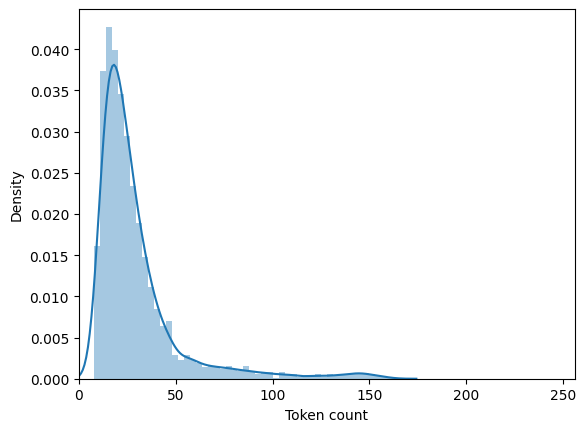

In [14]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [16]:
MAX_LEN = 150

In [29]:
class GPReviewDataset(Dataset):

  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [30]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [31]:
df_train.shape, df_val.shape, df_test.shape

((3988, 3), (855, 3), (855, 3))

In [32]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    text=df.text.to_numpy(),
    targets=df.target.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [33]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [34]:
train_data_loader

In [35]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

dict_keys(['text', 'input_ids', 'attention_mask', 'targets'])

In [36]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 150])
torch.Size([32, 150])
torch.Size([32])


In [37]:
PRE_TRAINED_MODEL_NAME = 'sagorsarker/bangla-bert-base'
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [40]:
bert_model.config.hidden_size

768

In [43]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    pooled_output = outputs.pooler_output
    output = self.drop(pooled_output)
    return self.out(output)


In [44]:
class_names = ['personal', 'political', 'religious', 'geopolitical']
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [45]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 150])
torch.Size([32, 150])


In [46]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.1946, 0.3229, 0.2144, 0.2682],
        [0.3257, 0.1600, 0.2890, 0.2253],
        [0.3048, 0.1476, 0.2458, 0.3018],
        [0.3040, 0.2321, 0.1880, 0.2760],
        [0.2238, 0.3346, 0.2538, 0.1878],
        [0.3047, 0.1759, 0.2989, 0.2205],
        [0.2886, 0.2272, 0.2172, 0.2670],
        [0.2668, 0.1631, 0.2576, 0.3126],
        [0.1637, 0.3550, 0.3105, 0.1709],
        [0.1289, 0.2364, 0.4611, 0.1736],
        [0.2506, 0.1896, 0.1965, 0.3632],
        [0.3518, 0.1576, 0.2534, 0.2371],
        [0.2608, 0.1856, 0.2645, 0.2891],
        [0.2241, 0.1073, 0.3467, 0.3219],
        [0.2202, 0.3079, 0.2267, 0.2452],
        [0.1585, 0.1625, 0.4168, 0.2621],
        [0.2336, 0.2758, 0.2101, 0.2806],
        [0.2296, 0.1971, 0.2304, 0.3428],
        [0.1633, 0.2137, 0.3845, 0.2384],
        [0.2608, 0.2001, 0.2618, 0.2773],
        [0.2747, 0.2326, 0.1793, 0.3134],
        [0.2873, 0.1517, 0.3598, 0.2012],
        [0.3296, 0.2304, 0.1873, 0.2527],
        [0.1959, 0.3759, 0.1443, 0

In [47]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [48]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [49]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)


In [50]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/3
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.6465521440505981 accuracy 0.7695586760280843


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.48042972496262304 accuracy 0.8421052631578948

Epoch 2/3
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.3040875273346901 accuracy 0.9002006018054163


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.4939025110668606 accuracy 0.8315789473684211

Epoch 3/3
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.16383709117770195 accuracy 0.9445837512537613


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.5187640350174021 accuracy 0.8444444444444444

CPU times: user 4min 30s, sys: 6.48 s, total: 4min 36s
Wall time: 5min 51s


In [51]:
x = np.array([float(tensor) for tensor in history['train_acc']])
y = np.array([float(tensor) for tensor in history['val_acc']])

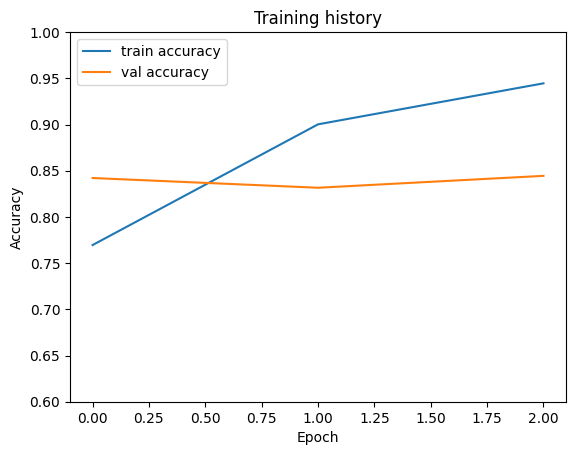

In [52]:
plt.plot(x, label='train accuracy')
plt.plot(y, label='val accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.6, 1]);
plt.show()

In [53]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

0.8596491228070176

In [56]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [57]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

In [58]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    personal       0.89      0.88      0.89       322
   political       0.79      0.81      0.80       132
   religious       0.81      0.87      0.84       146
geopolitical       0.88      0.85      0.87       255

    accuracy                           0.86       855
   macro avg       0.85      0.85      0.85       855
weighted avg       0.86      0.86      0.86       855



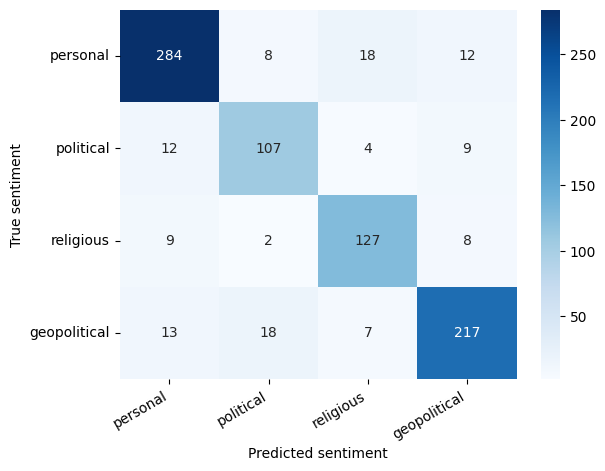

In [59]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [60]:
idx = 4

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [61]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

 ওর পুরস্কার ফেরত নেওয়া হোক আর ফাসি দেওয়া হোক

True sentiment: personal


In [62]:
for idx in range(10):
  review_text = y_review_texts[idx]
  true_sentiment = y_test[idx]
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': y_pred_probs[idx]
  })
  print("\n".join(wrap(review_text)))
  print(f'True sentiment: {class_names[true_sentiment]}')
  print()

ইন্ডিয়ার হিন্দুরা শুন মুসলিমদের সাথে ভাল ব্যাবহার কর নাইলে কপালে দুঃখ
আছে।
True sentiment: religious

তারিফ হাসান রেন্ডিয়াতে কি তুরে মাকে ভাডা দেচ? মালাউনের
বাচ্চা।মুস্লিমদের প্রতি দরদ নাই।শালা মুনাফেক মাদারিচুদ
True sentiment: geopolitical

এই জানোয়ারের বাচ্চাকে গণধোলাই দেয়ার আহ্বান রইল বাংলাদেশের কোটি কোটি
তৌহিদী জনতার প্রতি
True sentiment: geopolitical

অভিনেত্রীর দেয়া সেই কলমগুলোই দেখা যাচ্ছে ছাত্রলীগ সন্ত্রাসীদের হাতে
True sentiment: geopolitical

 ওর পুরস্কার ফেরত নেওয়া হোক আর ফাসি দেওয়া হোক
True sentiment: personal

এই মহিলা একদিন হিমেশকে অসিকার না করে বসেফালতু মহিলা একটা
True sentiment: personal

ভারত কেন আক্রমণ করেনা?? ওদের মিলিটারি পাওয়ার তো ভালই আছে। তাছাড়া
পাকিস্তানের কোন রাজ্যে কিছু হলেই ওরা যেভাবে মানবতা নেই বলে চিল্লায়
সেদিক চিন্তা করলে এতদিনে ওদের মায়ানমার আক্রমণ করা উচিত ছিলো। নাকি ওদের
মায়াকান্না শুধু বাংলাদেশ আর পাকিস্তানের জন্য সীমাবদ্ধ??
True sentiment: geopolitical

এটাকি কোন ভারতীয় পেজ নাকি।হেডিং দেখে তো তাই মনে হচ্ছে।
True sentiment: geopolitical

করোনা ভাইরাসের

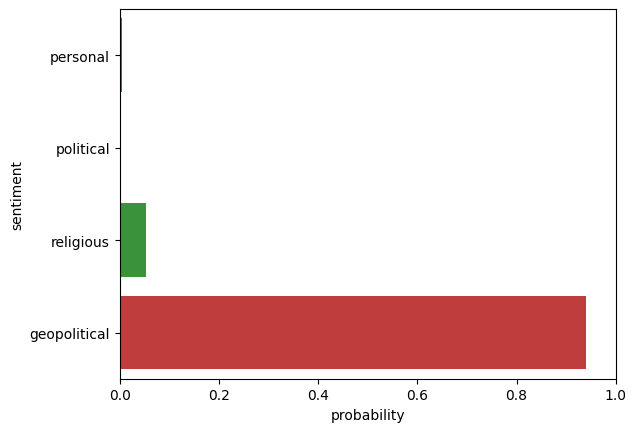

In [63]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [64]:
def check_model(review_text):
  encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
  )
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)

  print(f'Review text: {review_text}')
  print(f'Sentiment  : {class_names[prediction]}')

In [71]:
text1 = "বর্তমান সরকার দেশের জন্য ক্ষতিকর এদের যত দ্রুত সম্ভব বের করতে হবে"
text2 = "রাকিবের জন্য আজকে এই অবস্থা নাহয় ভালো কিছু হত"
text3 = "ভারতীয় রাজনীতিবিদরা দেশে ধর্ম নিয়ে ব্যবসা করছে"
text4 = "যে ধর্মগ্রনত মানেনা ওর সাথে ধর্ম নিয়ে আলোচনা করব কেন?"

In [72]:
check_model(text1)
check_model(text2)
check_model(text3)
check_model(text4)

Review text: বর্তমান সরকার দেশের জন্য ক্ষতিকর এদের যত দ্রুত সম্ভব বের করতে হবে
Sentiment  : political
Review text: রাকিবের জন্য আজকে এই অবস্থা নাহয় ভালো কিছু হত
Sentiment  : personal
Review text: ভারতীয় রাজনীতিবিদরা দেশে ধর্ম নিয়ে ব্যবসা করছে
Sentiment  : geopolitical
Review text: যে ধর্মগ্রনত মানেনা ওর সাথে ধর্ম নিয়ে আলোচনা করব কেন?
Sentiment  : religious


In [73]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Research/Shared Task/Violence Inciting Text Detection (VITD) Bangla/model.pth')